__Import libraries__

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

__Import Data__

In [2]:
features = pd.read_csv('walmart-recruiting-store-sales-forecasting/features.csv',parse_dates=[1])
stores = pd.read_csv('walmart-recruiting-store-sales-forecasting/stores.csv')
test = pd.read_csv('walmart-recruiting-store-sales-forecasting/test.csv',parse_dates=[2])
train = pd.read_csv('walmart-recruiting-store-sales-forecasting/train.csv',parse_dates=[2])

__Merge data into 1 DataFrame__

In [3]:
train_data = pd.merge(left=pd.merge(left=train,right=stores,how='left'),right=features,how='left',on=['Store','Date','IsHoliday'])
test_data = pd.merge(left = pd.merge(left=test,right=stores,how='left'),right=features,how='left',on = ['Store','Date','IsHoliday'])

__Add Features__

In [4]:
train_data['CPI_cat'] = np.where(train_data.CPI<160,'LowCPI','HighCPI')
test_data['CPI_cat'] = np.where(test_data.CPI<160,'LowCPI','HighCPI')

train_data['Size_cat'] = np.where(train_data.Size<75000,'Small_Size',np.where(train_data.Size<175000,'Mid_Size','High_Size'))
test_data['Size_cat'] = np.where(test_data.Size<75000,'Small_Size',np.where(test_data.Size<175000,'Mid_Size','High_Size'))



In [5]:
sb_dates = pd.to_datetime(['2010-02-12','2011-02-11','2012-02-10','2013-02-08'])
labor_dates = pd.to_datetime(['2010-09-10','2011-09-09','2012-09-07','2013-09-06'])
thanksgiving_dates = pd.to_datetime(['2010-11-26','2011-11-25','2012-11-23','2013-11-29'])
christmas_dates = pd.to_datetime(['2010-12-31','2011-12-30','2012-12-28','2013-12-27'])



In [6]:
train_data['Which_Holiday'] = 'NoHoliday'
train_data.loc[(np.isin(train_data[['Date']].values, sb_dates.values).reshape(-1)),'Which_Holiday'] = 'Super_Bowl'
train_data.loc[(np.isin(train_data[['Date']].values, labor_dates.values).reshape(-1)),'Which_Holiday'] = 'Labor_Day'
train_data.loc[(np.isin(train_data[['Date']].values, thanksgiving_dates.values).reshape(-1)),'Which_Holiday'] = 'Thanksgiving'
train_data.loc[(np.isin(train_data[['Date']].values, christmas_dates.values).reshape(-1)),'Which_Holiday'] = 'Christmas'

test_data['Which_Holiday'] = 'NoHoliday'
test_data.loc[(np.isin(test_data[['Date']].values, sb_dates.values).reshape(-1)),'Which_Holiday'] = 'Super_Bowl'
test_data.loc[(np.isin(test_data[['Date']].values, labor_dates.values).reshape(-1)),'Which_Holiday'] = 'Labor_Day'
test_data.loc[(np.isin(test_data[['Date']].values, thanksgiving_dates.values).reshape(-1)),'Which_Holiday'] = 'Thanksgiving'
test_data.loc[(np.isin(test_data[['Date']].values, christmas_dates.values).reshape(-1)),'Which_Holiday'] = 'Christmas'


In [7]:
from math import ceil

def create_date_features(df):
    
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['weekofyear'] = df['Date'].dt.weekofyear
  
    

    def week_of_month(dt):
        """ Returns the week of the month for the specified date.
        """

        first_day = dt.replace(day=1)

        dom = dt.day
        adjusted_dom = dom + first_day.weekday()

        return int(ceil(adjusted_dom/7.0))
    
    df['weekofmonth'] = df['Date'].apply(week_of_month)
    
    df = df.drop('Date',axis=1)
    
    return df

__Create data for log scaled target__

In [105]:
train_log = train_data[train_data.Weekly_Sales>0]
train_log.loc[:,'Weekly_Sales_log'] = np.log(train_log.Weekly_Sales)


C:\Users\shahb\AnacondaPython\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\shahb\AnacondaPython\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


__Seperate targets__

In [106]:
weekly_sales = train_data.Weekly_Sales
weekly_sales_log = train_log.Weekly_Sales_log
weekly_sales_log_org = train_log.Weekly_Sales

train_data.drop('Weekly_Sales',axis=1,inplace=True)
train_log.drop(['Weekly_Sales_log','Weekly_Sales'],axis=1,inplace=True)


C:\Users\shahb\AnacondaPython\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


__Preprocessing__

In [ ]:
num_features = ['CPI','Unemployment','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
cat_features = ['CPI_cat','Size_cat','Type','IsHoliday','Which_Holiday']

In [ ]:
def one_hot_encoding(train,test,cat_features):
    ohe = OneHotEncoder()
    
    ohe_train = ohe.fit_transform(train[cat_features]).toarray()
    ohe_train = pd.DataFrame(ohe_train,columns=ohe.get_feature_names())
    train.drop(cat_features,axis=1,inplace=True)
    train.reset_index(drop=True,inplace=True)
    train = pd.concat([train,ohe_train],axis=1)
    
    ohe_test = ohe.transform(test[cat_features]).toarray()
    ohe_test = pd.DataFrame(ohe_test,columns=ohe.get_feature_names())
    test.drop(cat_features,axis=1,inplace=True)
    test.reset_index(drop=True,inplace=True)
    test = pd.concat([test,ohe_test],axis=1)
    
    return (train,test)
    

In [ ]:
train_data,test_data = one_hot_encoding(train_data,test_data,cat_features)

In [ ]:
train_data.head()

In [ ]:
def imputing(train,test,num_features):
    imputer = SimpleImputer(strategy='constant',fill_value=0)

    imp_train = pd.DataFrame(imputer.fit_transform(train[num_features]),columns=num_features)
    train[num_features] = imp_train
    
    imp_test = pd.DataFrame(imputer.transform(test[num_features]),columns=num_features)
    test[num_features] = imp_test
    
    return train,test
    

In [ ]:
train_data,test_data = imputing(train_data,test_data,num_features)

In [ ]:
X = create_date_features(train_data)

In [ ]:
X.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, weekly_sales, test_size=0.30, shuffle=False)

In [ ]:
X_train.head()

In [ ]:
def custom_loss_scorer(estimator,X,y):
    weight_array = np.where(X.x3_True==1,5,1)
    preds = estimator.predict(X)
    error = np.mean(weight_array*np.abs(y-preds))
    
    return error

In [1]:
xgb_clf = XGBRegressor() 
parameters = {'n_estimators': [100], 
              'max_depth':[3],
              #'gamma':[0.1,0.3,0.5,0.7],
              #'min_child_weight':[1,3,5,7]
              'learning_rate': [0.05]
             }
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=parameters,scoring=custom_loss_scorer, cv=3, n_jobs=-1,verbose=3)
grid_search.fit(X_train, y_train)
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters=grid_search.best_estimator_.get_params()
print(best_parameters)

NameError: name 'XGBRegressor' is not defined

In [ ]:
preds = grid_search.predict(X)

In [69]:
from fbprophet import Prophet

In [70]:
m = Prophet()

In [72]:
df = pd.DataFrame({'ds':pd.to_datetime(store_1_1.Date[:120]),'y':sales_1_1[:120]})

In [73]:
m.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [74]:
(len(store_1_1.Date))

143

In [75]:
future= m.make_future_dataframe(periods = (len(store_1_1.Date)-120), freq='W')

In [76]:
future.tail()

,ds
138,2012-09-23
139,2012-09-30
140,2012-10-07
141,2012-10-14
142,2012-10-21


In [78]:
forecast = m.predict(future)

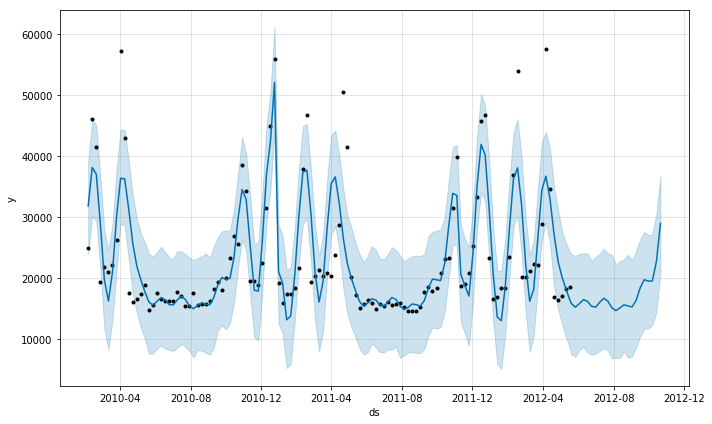

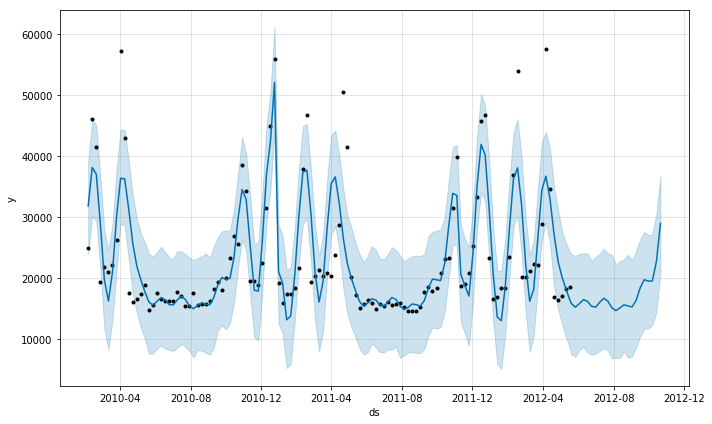

In [79]:
m.plot(forecast)

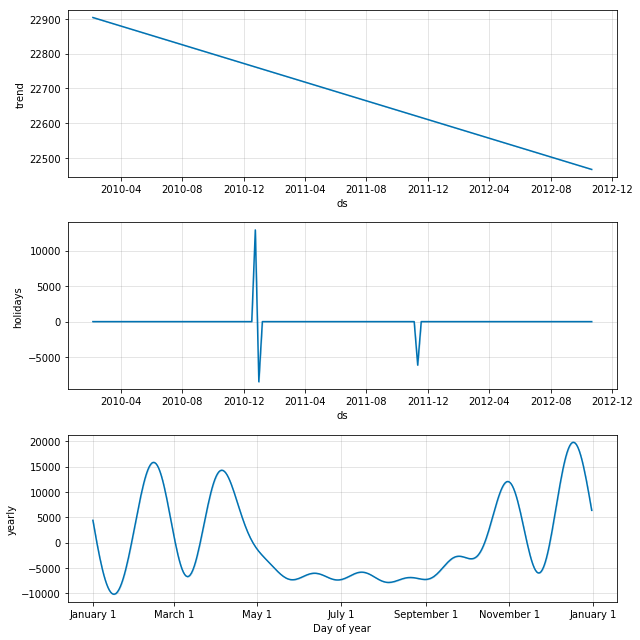

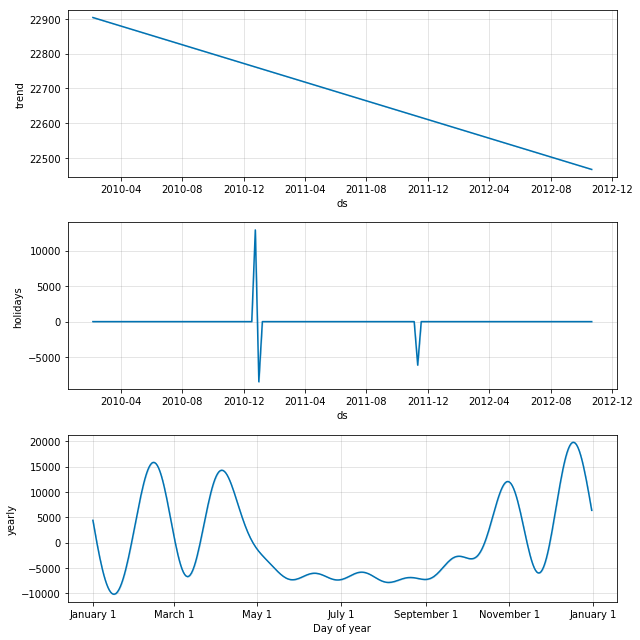

In [96]:
m.plot_components(forecast)

In [91]:
df_pred = pd.DataFrame()

In [92]:
df_pred['Weekly_sales'] = sales_1_1
df_pred['pred'] = forecast.yhat

In [93]:
df_pred.set_index(pd.to_datetime(store_1_1.Date),inplace=True)

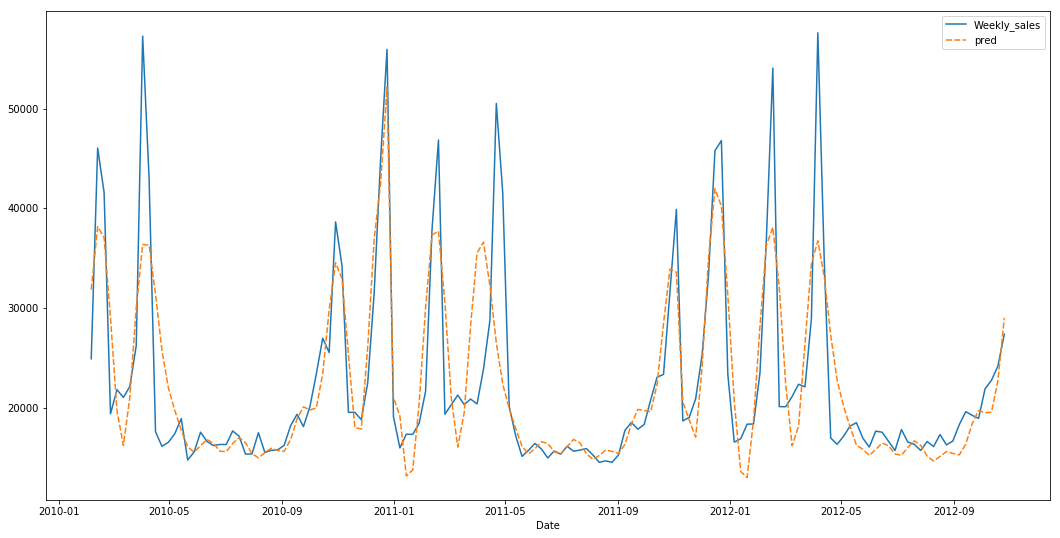

In [94]:
fig = plt.figure(figsize=(18,9))
sns.lineplot(data=df_pred)